# Figure S4: Cell type proportions stacked barplots

In [1]:
import numpy as np
import seaborn as sns

import sys
sys.path.append("/code/")
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_erode as cerd
from abc_merfish_analysis import diversity_metrics as divmet
from abc_merfish_analysis import diversity_plots as dplot

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # set to Illustrator-compatible font type
rcParams['font.size'] = 7  # set font size for plots to minimum recommended

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load data

In [2]:
# Load cell metadata
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [3]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# erode ccf structures to correct for boundary effects
parcellation_level = 'structure'
obs_erode, _ = cerd.label_cells_by_eroded_ccf(
                                            obs_th, 
                                            ccf_images,
                                            ccf_level=parcellation_level,
                                            distance_px=5, # default is erosion by 5px (5um)
                                            )

# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, cerd._ERODED_CCF_INDEX_COL] = np.nan#'unassigned'

# generate metrics for the eroded CCF structure
ccf_label=f'parcellation_{parcellation_level}_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

## Set figure saving behavior

In [4]:
results_dir = '../../results'
figure_index = 'S4'

## Plots

In [5]:
# Rank thalamic nuclei by their *CLUSTER* diversity, as measured by the inverse simpson's index (ISI)
# We'll use this to set the order of the y-axis for all 3 taxonomy levels
taxonomy_level = 'cluster'
metrics_to_sort_by = th_ccf_metrics.loc[abc.TH_DIVERSITY_STRUCTURES,:]
isi_sorted_metrics = metrics_to_sort_by.sort_values(
                                by=[f'inverse_simpsons_{taxonomy_level}'],
                                ascending=False
                                )
isi_sorted_regions = isi_sorted_metrics.index

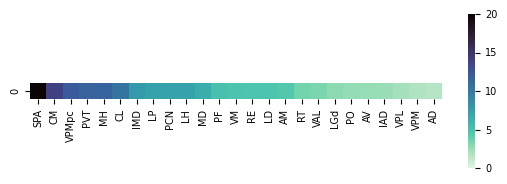

In [6]:
# Show cluster ISI ranking as a heatmap
cmap = sns.color_palette("mako_r", as_cmap=True) 
fig_isi_rank, ax = plt.subplots(figsize=(6.65,2))
sns.heatmap(
    [isi_sorted_metrics[f'inverse_simpsons_{taxonomy_level}'].values],#),
            square=True, 
            vmin=0,
            vmax=20,
            cmap=cmap,
            xticklabels=isi_sorted_regions,
            ax=ax)

fig_isi_rank.savefig(f'{results_dir}/fig{figure_index}_diversity_rank_1Dheatmap_isi_cluster_ALL_NUCLEI.pdf', 
                     transparent=True, bbox_inches='tight')

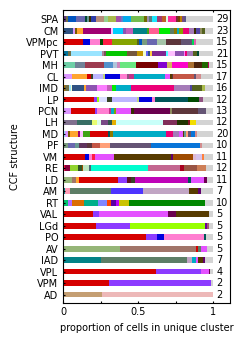

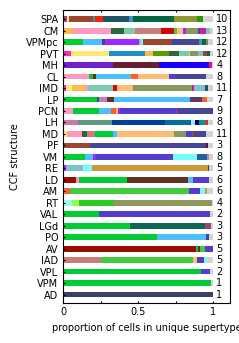

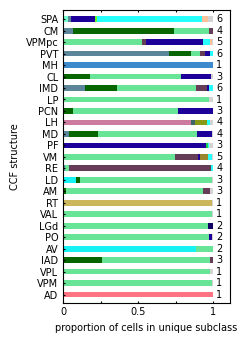

In [7]:
# cell type proportions as bar plots
taxonomy_levels = ['cluster', 'supertype', 'subclass']
for taxonomy_level in taxonomy_levels:
    fig_bar = dplot.barplot_stacked_proportions(
        obs_erode, 
        taxonomy_level, 
        th_ccf_metrics, 
        palette=abc.get_thalamus_cluster_palette() if taxonomy_level=='cluster' else abc.get_taxonomy_palette(taxonomy_level),
        ccf_regions=abc.TH_DIVERSITY_STRUCTURES,
        legend=False, 
        min_cell_frac=0.01,  # lump categories that are <=1% of cells in that region into "other" category 
                             # also considered: min_cell_frac=0.05 
        ordered_regions=isi_sorted_regions,
        orientation='horizontal',
    )
    fig_bar.set_size_inches(2.15,3.8)
    fig_bar.gca().tick_params(length=0.02*72)

    fig_bar.savefig(
        f'{results_dir}/fig{figure_index}_nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}_ALL_NUCLEI.pdf', 
        transparent=True, bbox_inches='tight')